# PINNS - Test

In [6]:
import torch
import numpy as np
import time
import sys

In [7]:
np.random.seed(42)
torch.manual_seed(42)

# Check if we run on GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Running on {device}. Have fun!")

Running on cpu. Have fun!


In [8]:
# PDE configurations
a1 = 2
a2 = 1
k  = 1

In [9]:
# Data
## Domain bounds
x_bound_low = -1
x_bound_up  =  1
y_bound_low = -1
y_bound_up  =  1
bounds = [x_bound_low, x_bound_up, y_bound_low, y_bound_up]

In [10]:
## Test points
num_test_x =  120
num_test_y =  120

In [11]:
X, Y       = np.meshgrid(np.linspace(x_bound_low,x_bound_up,num_test_x), np.linspace(y_bound_low,y_bound_up,num_test_y))
Test_exact = (np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)).flatten()[:,None]  # Exact solution
X_test     = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))                # Test points

In [12]:
X_test

array([[-1.        , -1.        ],
       [-0.98319328, -1.        ],
       [-0.96638655, -1.        ],
       ...,
       [ 0.96638655,  1.        ],
       [ 0.98319328,  1.        ],
       [ 1.        ,  1.        ]])

In [13]:
def RandomSampling(Ncollocation, Nbounds, bounds):
    ## Collocation points, inside domain for training
    x = np.random.uniform(bounds[0], bounds[1], Ncollocation)
    y = np.random.uniform(bounds[2], bounds[3], Ncollocation)
    X_f_train = np.hstack((x.flatten()[:,None], y.flatten()[:,None]))
    
    ## Boundaries
    ### boundaries up and down
    x_bc_u = np.random.uniform(bounds[0], bounds[1], Nbounds)
    y_bc_u = np.full(Nbounds, bounds[3])
    x_bc_d = np.random.uniform(bounds[0], bounds[1], Nbounds)
    y_bc_d = np.full(Nbounds, bounds[2])
    ### boundaries left and right
    y_bc_l = np.random.uniform(bounds[2], bounds[3], Nbounds)
    x_bc_l = np.full(Nbounds, bounds[0])
    y_bc_r = np.random.uniform(bounds[2], bounds[3], Nbounds)
    x_bc_r = np.full(Nbounds, bounds[1])

    X_star = np.hstack((np.vstack([x_bc_u,x_bc_d,x_bc_l,x_bc_r]).flatten()[:,None], np.vstack([y_bc_u,y_bc_d,y_bc_l,y_bc_r]).flatten()[:,None]))
    return X_f_train, X_star

In [14]:
## Train points
Ncollocation      = 1024
Nbounds           = 256
X_f_train, X_star = RandomSampling(Ncollocation, Nbounds, bounds)
Exact_bc          = np.zeros(X_star.shape[0]).flatten()[:,None]
lb                = X_star.min(0)
ub                = X_star.max(0)

In [15]:
class FCN(torch.nn.Module):
    
    def __init__(self, X_bc, U_bc, X_f, X_test, U_exact, layers, lb, ub, a1, a2, k, device):
        super().__init__() 
        # bounds
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # data
        ## Boundaries
        self.X_bc = torch.tensor(X_bc, requires_grad=True).float().to(device)  # Boundary points
        self.U_bc = torch.tensor(U_bc).float().to(device)                      # Field Value at boundary

        ## Domain, collocation points'
        self.x        = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) 
        self.y        = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.residu_target = torch.zeros(X_f.shape[0],1).to(device)

        ## Test
        self.X_test  = torch.tensor(X_test , requires_grad=False).float().to(device) # Test points
        self.U_exact = torch.tensor(U_exact, requires_grad=False).float().to(device) # Exact value

        # PDE parameters
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.k  = k
        self.a1 = a1
        self.a2 = a2

        # NN
        self.layers = layers
        self.best   = np.Infinity
              
        ## activation function
        self.activation = torch.nn.Tanh()
        ## loss function
        self.loss_function = torch.nn.MSELoss(reduction ='mean')
        ## Initialize neural network as a list using nn.Modulelist' 
        self.linears = torch.nn.ModuleList([torch.nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        
        self.iter = 0
        ## Xavier Normal Initialization
        for i in range(len(self.layers)-1):
            torch.nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            torch.nn.init.zeros_(self.linears[i].bias.data)
            
    ## forward pass
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = self.ub[0]
        l_b = self.lb[0]
        x   = (x - l_b)/(u_b - l_b)
        a   = x.float()

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
                        
    def loss_BC(self,bc_points,u_bc):
        loss_bc = self.loss_function(self.forward(bc_points), u_bc)
        return loss_bc
 
    def loss_PDE(self, x, y):
        u = self.forward(torch.hstack((x, y)))
        s = ( -(self.a1*self.pi)**2 - (self.a2*self.pi)**2 + self.k**2 ) * torch.sin(self.a1*self.pi*x) * torch.sin(self.a2*self.pi*y)
        
        u_x  = torch.autograd.grad(u  , x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y  = torch.autograd.grad(u  , y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
        residu = u_xx + u_yy + self.k**2 * u - s                 
        
        loss_f = self.loss_function(residu,self.residu_target)
        return loss_f
    
    def loss(self):
        loss_bc  = self.loss_BC(self.X_bc,self.U_bc)
        loss_f   = self.loss_PDE(self.x,self.y)
        loss_val = loss_bc + loss_f
        return loss_val, loss_bc, loss_f
    
    def closure(self):
        self.optimizer.zero_grad()
        loss, loss_bc, loss_f = self.loss()
        loss.backward()
        return loss, loss_bc, loss_f       

    def train(self, model, nstep=100, log_every=100, LossFile='Loss.dat'):
        start_time = time.time()
        tin=time.time()

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
        with open(LossFile, 'w') as f:
            f.write(f"# Iter         Loss       Loss BC      Loss Dom.\n")
            for it in range(nstep):
                loss, loss_bc, loss_f = self.optimizer.step(model.closure)
                # Test the model and log information 
                if self.iter % log_every == 0:
                    error_vec, _ = self.test()
                    f.write(f"{self.iter:6d} {loss.item():12f}, {loss_bc.item():12f}, {loss_f.item():12f}\n")
                    print(f"{self.iter:6d}: Loss = {loss.item():>12.5f}; Error = {error_vec.item():<12.5f}")
                # Save the model if it improves
                if loss.item() < self.best:
                    torch.save(self.state_dict(), "model.pt")
                    self.best = loss.item()
                self.iter += 1
        
        tout=time.time()
        print("Elapsed: ",tout-tin," seconds")
    
    def test(self):
        u_pred = self.forward(self.X_test)
        error_vec = torch.linalg.norm((self.U_exact-u_pred),2)/torch.linalg.norm(self.U_exact,2)
        u_pred = u_pred.cpu().detach().numpy()
        return error_vec, u_pred


In [18]:
# NN configuration
layers = [2, 256, 256, 1]

# Training Time
model = FCN(X_star, Exact_bc, X_f_train, X_test, Test_exact, layers, lb, ub, a1, a2, k, device)
model.to(device)

model.train(model, nstep=3000, log_every=500, LossFile='Loss.dat')

''' Model Accuracy '''
model.load_state_dict(torch.load("model.pt"))
error_vec, u_pred = model.test()
error_u = np.linalg.norm(Test_exact-u_pred,2)/np.linalg.norm(Test_exact,2)
print('Error u: %e' % (error_u))
Error = np.abs(Test_exact - u_pred)



     0: Loss =    591.42438; Error = 1.03859     
   500: Loss =      0.13765; Error = 0.13841     
  1000: Loss =      0.03910; Error = 0.09269     
  1500: Loss =      0.02994; Error = 0.06335     
  2000: Loss =      0.00999; Error = 0.04736     
  2500: Loss =      0.00730; Error = 0.03945     
Elapsed:  176.12952399253845  seconds
Error u: 3.213914e-02


Text(0.5, 1.0, 'Exact')

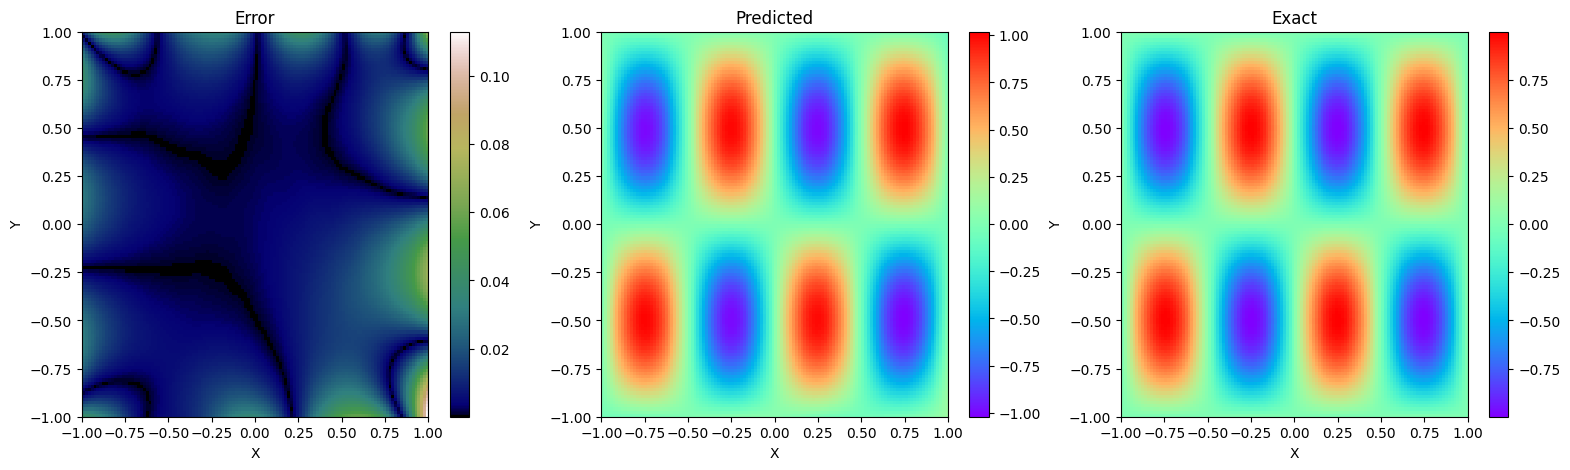

In [19]:
import matplotlib.pyplot as plt
    
outputfile="output.png"    
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(19)

# Plot the Error
ax1 = plt.subplot(1, 3, 1)
shw1 = plt.imshow(Error.reshape((num_test_x, num_test_y)), cmap='gist_earth', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw1)
plt.xlabel('X')
plt.ylabel('Y')
ax1.set_title("Error")

# Plot the Predicted values for the NN
ax2 = plt.subplot(1, 3, 2)
shw2 = plt.imshow(u_pred.reshape((num_test_x, num_test_y)), cmap='rainbow', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw2)
plt.xlabel('X')
plt.ylabel('Y')    
ax2.set_title("Predicted")

# Plot the exact solution
plt.subplot(1, 3, 3)
ax3 = plt.subplot(133)
shw3 = plt.imshow(Test_exact.reshape((num_test_x, num_test_y)), cmap='rainbow', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw3)
plt.xlabel('X')
plt.ylabel('Y')  
ax3.set_title("Exact")